In [1]:
import numpy as np
from numpy.linalg import inv,norm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import minimize, root, linprog
np.set_printoptions(precision=4, suppress=True)
matplotlib.rcParams.update({'font.size': 11, 'font.family': 'serif'})

In [2]:
class Parameters():
    def __init__(self):
        self.z_lb = None
        self.z_ub = None
        self.p_lb = None
        self.p_ub = None
        self.x_ub = None
        self.x_lb = None
        self.E = None
        self.w = None
        self.radius = None
        self.n = None
        self.m = None
        self.k = None
        self.epsilon = None
    
    
class Segment:

    def __init__(self, a_range, b, n, share):
        self.a = np.random.uniform(a_range[0], a_range[1], size=n)
        self.b = b
        self.share = share
        
    def compute_bounds_x(self, p_lb, p_ub):
        self.x_lb = 1 / (1 + np.sum(np.exp(self.a - self.b * p_lb)))
        self.x_ub = 1 / (1 + np.sum(np.exp(self.a - self.b * p_ub)))
     
    
class Cube:
    def __init__(self, center, radius, theta_start=None):
        self.feasible = False
        self.center = center
        self.bottomcorner = center - radius
        self.r = radius
        self.nu_bar = None
        self.nu_ubar = None
        self.lam = None
        self.delta_plus = None
        self.delta_min = None
        self.new_x = None
        self.D = None
        self.dDdx = None
        self.dDdx_norm_ub = None
        self.D_ub = None
        self.outside_X = False
        self.suboptimal = None
        self.theta_start = theta_start
        self.rev_ub = None

        
def q0(p, segments):
    return np.asarray([1 / (1 + np.sum(np.exp(c.a - p * c.b))) for c in segments])


def alpha(u, par):
    return np.sum(par.E.T * par.w.reshape(-1,1) / (1 + u).reshape(-1,1), axis=0) / par.b


def q(p, segments, par):
    q_ = np.asarray([np.exp(c.a - p * c.b) /
                     (1 + np.sum(np.exp(c.a - p * c.b))) for c in segments])
    return np.sum(par.w.reshape(-1,1) * q_, axis=0)


def rev(p, segments):
    return - np.sum([c.share * np.sum(p * np.exp(c.a - c.b * p)) /
                     (1 + np.sum(np.exp(c.a - c.b * p))) for c in segments])


def pi_c(pi, segment, b):
    return pi - np.sum(1 / b * np.exp(segment.a - 1 - b * pi))


def drdp(p, segments, b):
    q0 = np.asarray([1 / (1 + np.sum(np.exp(c.a - b * p))) for c in segments])
    q = [np.exp(c.a - b * p) / (1 + np.sum(np.exp(c.a - b * p))) for c in segments]
    return np.sum([c.share * q0[ci] * (b * q[ci] * np.sum(p * np.exp(c.a - b * p)) -
                  (b * p - 1) * np.exp(c.a - b * p)) for ci,c in enumerate(segments)],axis=0)


def dDdx(cube, par):
    u = (1 - cube.center) / cube.center
    z = np.exp((cube.lam.dot(par.E.T) - cube.nu_ubar + cube.nu_bar) / alpha(u,par) - 1)
    return cube.lam / cube.center**2 - par.w * par.E.T.dot(z * np.log(z) / par.b)


def dDdx_norm_ub(cube, par):
    
    E = par.E
    x = cube.center
    lam = cube.lam
    r = cube.r
    
    x_ = x + r
    u = (1 - x_) / x_
    z = np.exp((lam.dot(E.T) - cube.nu_ubar + cube.nu_bar) / alpha(u, par) - 1)
    i = (lam / ((lam > 0) * np.square(x - r) +
                (lam < 0) * np.square(x + r))
         - par.w * E.T.dot(z * np.log(z) / par.b))

    x_ = x - r
    u = (1 - x_) / x_
    z = np.exp((lam.dot(E.T) - cube.nu_ubar + cube.nu_bar) / alpha(u, par) - 1)
    ii = (par.w * E.T.dot(z * np.log(z) / par.b)
          - lam / ((lam > 0) * np.square(x + r) +
                   (lam < 0) * np.square(x - r)))

    return np.max([np.max(i), np.max(ii)])


def check_feasibility_cube(cube, par):

    r = par.radius
    x = cube.center
    u = (1 - x) / x

    b_eq = u
    c = np.hstack([np.zeros(par.n + 2 * par.m), np.ones(1)])
    A_eq = np.hstack([par.E.T, np.identity(par.m),
                      -np.identity(par.m),
                      np.zeros((par.m, 1))])

    A_ub_1 = np.hstack([np.zeros((par.m, par.n)),
                        np.identity(par.m),
                        np.identity(par.m),
                        -np.ones((par.m,1))])

    b_ub_1 = np.zeros(par.m)

    A_ub_2 = np.hstack([np.zeros((par.m, par.n)),
                        np.identity(par.m),
                        np.zeros((par.m, par.m)),
                        np.zeros((par.m,1))])

    b_ub_2 = u - (1 - (x + r)) / (x + r)
    
    A_ub_3 = np.hstack([np.zeros((par.m, par.n)),
                        np.zeros((par.m, par.m)),
                        np.identity(par.m),
                        np.zeros((par.m,1))])

    b_ub_3 = (1 - (x - r)) / (x - r) - u
    
    A_ub_4 = np.hstack([-np.identity(par.n),
                        np.zeros((par.n,par.m)),
                        np.zeros((par.n,par.m)),
                        np.zeros((par.n,1))])
    
    b_ub_4 = - par.z_lb
    
    A_ub_5 = np.hstack([np.identity(par.n),
                        np.zeros((par.n,par.m)),
                        np.zeros((par.n,par.m)),
                        np.zeros((par.n,1))])
    
    b_ub_5 = par.z_ub

    A_ub = np.vstack([A_ub_1, A_ub_2, A_ub_3, A_ub_4, A_ub_5])
    b_ub = np.hstack([b_ub_1, b_ub_2, b_ub_3, b_ub_4, b_ub_5])

    return linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub)


def compute_bounds_p_x(segments, par):
    
    # compute upper bound on segment revenues
    ub_pi = []
    for segment in segments:
        res = root(pi_c, 5.0, args=(segment, par.b))
        if not res.success:
            raise Exception('Root finding not success')
        else:
            ub_pi.append(res.x)

    # compute upper bound on prices
    par.p_ub = 1 / par.b + np.max(ub_pi)
    par.p_lb = 1 / par.b
    
    for segment in segments:
        segment.compute_bounds_x(par.p_lb, par.p_ub)
        
    return segments, par


def D(theta, u, par, segments):
    lam = theta[:par.m]
    nu_ubar = np.exp(theta[par.m:par.n+par.m])
    nu_bar = np.exp(theta[par.n+par.m:])
    alpha_val = alpha(u, par)
    z = np.exp((par.E.dot(lam) + nu_bar - nu_ubar) / alpha_val - 1)
    return (np.inner(alpha_val, z)
            - np.inner(lam,u)
            + np.inner(nu_ubar, par.z_lb)
            - np.inner(nu_bar, par.z_ub))


def minimize_D(cube, par, segments):
    success = False
    u = (1 - cube.new_x) / cube.new_x
    count_tries = 0
    theta_start = cube.theta_start
    while not success:
        count_tries += 1
        out = minimize(D, theta_start, args=(u, par, segments)) 
        if out.success:
            success = True
        elif count_tries > 10:
            exc = (f'lagrange optimization failed at cube.center {1/(1+u)}' +
                   f' and par.radius {par.radius}')
            raise Exception(exc)
        theta_start = np.random.uniform(-20.0, -50.0, size=2*par.n+par.m)
    return out


def iterate_cubes(cubes, segments, rev_lb, par):
    
    b = par.b
    p_lb = par.p_lb
    p_ub = par.p_ub

    toremove = []
    
    for cube in cubes:

        # remove cubes that are completely outside X
        if np.any(cube.bottomcorner > par.x_ub):
            cube.outside_X = True
            toremove.append(cube)
        
        # check if feasible for the other cubes
        else:
            
            feasibility_cube = check_feasibility_cube(cube, par)
            cube.feasible = feasibility_cube.success
            
            if cube.feasible:
                
                cube.delta_plus = feasibility_cube.x[par.n:par.n+par.m]
                cube.delta_min = feasibility_cube.x[par.n+par.m:par.n+2*par.m] 
                u = (1 - cube.center) / cube.center - cube.delta_plus + cube.delta_min
                cube.new_x = 1 / (1 + u)
                opt = minimize_D(cube, par, segments)
                cube.theta_start = opt.x
                cube.lam = opt.x[:par.m]
                cube.nu_ubar = np.exp(opt.x[par.m:par.n+par.m])
                cube.nu_bar = np.exp(opt.x[par.m+par.n:])
                cube.D = opt.fun
                cube.dDdx = dDdx(cube, par)
                cube.dDdx_norm_ub = dDdx_norm_ub(cube, par)
                cube.D_ub = cube.D + cube.r * cube.dDdx_norm_ub
                
                if cube.D > rev_lb:
                    rev_lb = cube.D
                
                r = cube.r + np.max(np.abs(cube.center - cube.new_x))
                cube.rev_ub = cube.D + cube.dDdx_norm_ub * r

                if cube.rev_ub < rev_lb:
                    cube.suboptimal = True
                    toremove.append(cube)
                
            else:
                toremove.append(cube)
        
    return toremove, rev_lb, cubes


def find_initial_estimate(par, segments):
    
    foundoptimum = False
    attempt_count = 0
    max_attempts = 5
    rev_lb = 0

    while attempt_count <= max_attempts:

        attempt_count += 1
        pstart = np.random.uniform(par.p_lb, par.p_ub)
        sol = minimize(rev, pstart, args=(segments, ))
        rev_opt = -sol.fun

        if rev_opt > rev_lb:
            solmax = sol
            rev_lb = rev_opt

    par.rev_lb_x = q0(solmax.x, segments)
    par.solmax = solmax
    
    return par, rev_lb


def plot_grid(ax, cubes, cubes_to_plot, segments, x_axis=True, y_axis=True):
    
    c1 = segments[0]
    c2 = segments[1]
    
    _ = np.min([c1.x_lb, c2.x_lb])
    ax.scatter(_, _, facecolor='none')
    _ = np.max([c1.x_ub, c2.x_ub])
    ax.scatter(_, _, facecolor='none')  

    for cube in cubes_to_plot:
        
        if cube.outside_X:
            ax.add_patch(
                patches.Rectangle(
                    cube.bottomcorner,
                    2 * cube.r,
                    2 * cube.r,
                    facecolor='darkgrey',
                    edgecolor='white'
                )
            )
        
        elif not cube.feasible: 
            ax.add_patch(
                patches.Rectangle(
                    cube.bottomcorner,
                    2 * cube.r,
                    2 * cube.r,
                    facecolor='darkgrey',
                    edgecolor='white'
                )
            )
            
        elif cube.suboptimal:
            ax.add_patch(
                patches.Rectangle(
                    cube.bottomcorner,
                    2 * cube.r,
                    2 * cube.r,
                    edgecolor='white',
                    facecolor='salmon',
                )
            )
        
        else:
            raise Exception('Cube is inside X and feasible.')
    
    for i,cube in enumerate(cubes):

        ax.add_patch(
            patches.Rectangle(
                cube.bottomcorner,
                2 * cube.r,
                2 * cube.r,
                facecolor='seagreen',
                edgecolor='white'
            )
        )
        
    ax.add_patch(
        patches.Rectangle(
            (c1.x_lb, c2.x_lb),
            c1.x_ub - c1.x_lb,
            c2.x_ub - c2.x_lb,
            fill=None,
            color='black',
            linestyle='--'
        )
    )
    
    ax.set_xticks([0.0,0.5,1.0])
    ax.set_yticks([0.0,0.5,1.0])
    
    if not x_axis: ax.xaxis.set_ticklabels([])
    if not y_axis: ax.yaxis.set_ticklabels([])


In [3]:
# set up parameters
n = 4
m = 2
seed = 222
if seed:
    np.random.seed(seed)    
max_cube_iterations = 10

a_range = (-1.0, 6.0)
b_range = (0.001, 0.01)
epsilon = 0.001

par = Parameters()
par.n = n
par.m = m
par.k = 0

# sample parameters
par.w = np.random.uniform(0,1,size=m)
par.w /= np.sum(par.w)
par.b = np.random.uniform(b_range[0], b_range[1], size=n)
segments = [Segment(a_range, par.b, n, w) for w in par.w]

par.b = np.asarray([0.03, 0.02, 0.025, 0.01])
par.w = np.asarray([0.5, 0.5])
segments[0].a = np.asarray([1.0, 2.0, 3.0, 4.0])
segments[0].share = par.w[0]
segments[0].b = par.b
segments[1].a = np.asarray([2.0, 1.0, 2.0, 1.0])
segments[1].share = par.w[1]
segments[1].b = par.b

# compute bounds
segments, par = compute_bounds_p_x(segments, par)
par.z_lb = np.exp(-par.p_ub * par.b)
par.z_ub = np.exp(-par.p_lb * par.b)
par.x_ub = np.asarray([segment.x_ub for segment in segments])
par.E = np.asarray([np.exp(segment.a) for segment in segments]).T
print('x-bounds on segments')

for c in segments:
    print(f"x_lb: {c.x_lb:.3f}, x_ub: {c.x_ub:.3f}")

# find good initial estimate
par, rev_lb = find_initial_estimate(par, segments)

# initialize cubes
newcubes = np.meshgrid(*([[-1,1] for _ in range(m)]))
newcubes = np.vstack(map(np.ravel, newcubes)).T
maxlen = np.max([c.x_ub - c.x_lb for c in segments])
par.radius = maxlen / 2
cubes = [Cube(np.asarray([c.x_lb for c in segments]) + par.radius,
              par.radius,
              theta_start=np.random.uniform(-20.0, -50.0, size=2*par.n+par.m))]
cubes_to_plot = []

k=0
stop = False

store_iterations = {'cubes': [], 'cubes_to_plot': []}

while not stop:

    k+=1
    print(f"rev_lb: {rev_lb}")
    toremove, rev_lb, cubes = iterate_cubes(cubes, segments, rev_lb, par)
    cubes = [cube for cube in cubes if not cube in toremove]
    cubes_to_plot = cubes_to_plot + toremove

    rel_error = np.max([cube.rev_ub / rev_lb for cube in cubes])
    print(f"\niteration: {k}, current relative error: {rel_error:.4f}")

    store_iterations['cubes'].append(cubes)
    store_iterations['cubes_to_plot'].append(cubes_to_plot)
        
    if rel_error < (1 + epsilon):
        print('stop because relative error max epsilon')
        stop = True
        
    elif k == max_cube_iterations:
        print('maxiter reached, relative error:', rel_error)
        stop = True
        
    else:
        par.radius = 0.5 * par.radius
        cubes = [Cube(cube.center + omega * par.radius,
                      par.radius,
                      theta_start=cube.theta_start)
                 for omega in newcubes for cube in cubes]

    print('len(cubes): ', len(cubes))

x-bounds on segments
x_lb: 0.031, x_ub: 0.308
x_lb: 0.119, x_ub: 0.881
rev_lb: 138.06101158323406

iteration: 1, current relative error: 198.9807
len(cubes):  4
rev_lb: 138.06101158323406

iteration: 2, current relative error: 37.5899
len(cubes):  8
rev_lb: 138.06101158323406


/Users/rvdgeer/.pyenv/versions/3.6.8/envs/fml-pricing/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



iteration: 3, current relative error: 8.2206
len(cubes):  32
rev_lb: 138.06101158323406

iteration: 4, current relative error: 2.1369
len(cubes):  84
rev_lb: 138.06101158323406

iteration: 5, current relative error: 2.1439
len(cubes):  132
rev_lb: 138.06101158323406

iteration: 6, current relative error: 1.4041
len(cubes):  128
rev_lb: 138.06101158323406

iteration: 7, current relative error: 1.0018
len(cubes):  108
rev_lb: 138.06101158323406

iteration: 8, current relative error: 1.0005
stop because relative error max epsilon
len(cubes):  26


In [5]:
no_x_axis = [1,2,3]
no_y_axis = [2,3,5,6]
fig = plt.figure()
for k in range(np.min([6,len(store_iterations['cubes'])])):
    
    ax = fig.add_subplot(2, 3, k+1, aspect='equal')
    plot_grid(ax,
              store_iterations['cubes'][k],
              store_iterations['cubes_to_plot'][k],
              segments,
              x_axis = False if k+1 in no_x_axis else True,
              y_axis = False if k+1 in no_y_axis else True
             )
    
    if k + 1 not in no_x_axis:
        ax.set_xlabel(r"$x_1$", size=12)
    if k + 1 not in no_y_axis:
        ax.set_ylabel(r"$x_2$", rotation=0, labelpad=10, size=12)
    
    ax.set_yticks(ax.get_xticks())
    ax.set_ylim(ax.get_xlim())
    
plt.tight_layout()
plt.savefig(f'../gridfigs/X_all.pdf', bbox_inches='tight')
plt.close()

In [6]:
from matplotlib import rc
rc('text', usetex=True)

In [7]:
a1 = segments[0].a
a2 = segments[1].a
b = par.b

# def pi_c(pi, a):
#     return pi - np.sum(1 / b * np.exp(a - 1 - b * pi))

# ub = 1 / b + np.max([root(pi_c, 5.0, args=(a1, )).x,
#                      root(pi_c, 5.0, args=(a2, )).x])
# lb = 1 / b

# bounds = [(lb[i], ub[i]) for i in range(len(a1))]

# def minimize_it(p):
#     return norm([x1i - 1 / (1 + np.sum(np.exp(a1 - p * b))), x2i - 1 / (1 + np.sum(np.exp(a2 - p * b)))])

# fig = plt.figure()
# ax = fig.add_subplot(111)

# x_range1 = np.linspace(segments[0].x_lb, par.x_ub[0], 200)
# x_range2 = np.linspace(segments[1].x_lb, par.x_ub[1], 200)

x_range1 = np.linspace(0, 1, 500)[1:]
x_range2 = np.linspace(0, 1, 500)[1:]
x1, x2 = np.meshgrid(x_range1, x_range2)
z = np.zeros(x1.shape)

for i in range(len(x_range1)):
    for j in range(len(x_range2)):
        x1i = x1[i,j]
        x2i = x2[i,j]
        cube = Cube(np.asarray([x1i,x2i]), 0.0)
        lp = check_feasibility_cube(cube, par)
        if lp.success:
            z[i,j] = 1

FileNotFoundError: [Errno 2] No such file or directory: 'figs/example_X.pdf'

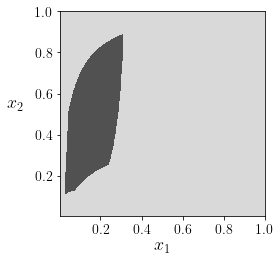

In [8]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
# ax = plt.gca()
ax.contourf(x1, x2, z, 1, cmap='Greys')
# plt.axis('equal')

ax.set_xlabel(r"$x_1$", size=18)
ax.set_ylabel(r"$x_2$", rotation=0, labelpad=20, size=18)
ax.set_xticks(ax.get_yticks())
ax.set_xlim(ax.get_ylim())
ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
ax.set_aspect('equal')
plt.savefig("../figs/example_X.pdf", bbox_inches='tight')
plt.show()

In [ ]:
for c in segments:
    print(f"x_lb: {c.x_lb:.3f}, x_ub: {c.x_ub:.3f}")

In [ ]:
par.p_lb

In [ ]:
par.p_ub

In [ ]:
# for cube in cubes:
#     print(f"\ncube.center: {cube.center}")
#     print(f"cube.D: {cube.D}")
#     print(f"cube.D_ub: {cube.D_ub}")

In [ ]:
cube = cubes[0]
r = par.radius
feasibility_cube = check_feasibility_cube(cube, par)
cube.delta_plus = feasibility_cube.x[par.n:par.n+par.m]
cube.delta_min = feasibility_cube.x[par.n+par.m:par.n+2*par.m] 
u = (1 - cube.center) / cube.center - cube.delta_plus + cube.delta_min
x = 1 / (1 + u)
cube.new_x = x
nu_bar, nu_ubar, lam = minimize_D(u, par, segments)

a = np.sum(E.T * shares.reshape(-1,1) / (1 + u).reshape(-1,1), axis=0) / par.beta
z = np.exp((lam.dot(E.T) - nu_ubar + nu_bar) / a - 1)

theta = np.hstack([lam, np.log(nu_ubar), np.log(nu_bar)])

dDdx_norm_ub(x, r, E, par)

#     print(dDdx_norm_ub)

In [ ]:
par.radius

In [ ]:
# [1510.3086 1656.4918]
# 2007.0884921478105 1397.736907960258
# 2275.9093907032775 3413.669546323768

In [ ]:
D_(x, theta, E, z_lb, z_ub, par, segments)

In [ ]:
def D_(x):
    u = (1 - x) / x
    lam = theta[:par.m]
    nu_ubar = np.exp(theta[par.m:par.n+par.m])
    nu_bar = np.exp(theta[par.n+par.m:])
    shares = np.asarray([c.share for c in segments])
    a = np.sum(E.T * shares.reshape(-1,1) / (1 + u).reshape(-1,1), axis=0) / par.beta
    z = np.exp((lam.dot(E.T) + nu_bar - nu_ubar) / a - 1)
    return np.inner(a,z) - np.inner(lam,u) + np.inner(nu_ubar,z_lb) - np.inner(nu_bar,z_ub)


In [ ]:
import numdifftools as nd
from functools import partial

In [ ]:
nu_bar, nu_ubar, lam = minimize_D(u, E, z_lb, z_ub, par, segments)
a = np.sum(E.T * shares.reshape(-1,1) / (1 + u).reshape(-1,1), axis=0) / par.beta
z = np.exp((lam.dot(E.T) - nu_ubar + nu_bar) / a - 1)

print(z_lb)
print(z)
print(z_ub)

print('\n', z>=z_lb)
print(np.all(z<=z_ub))
print(np.all(z>=z_lb))

In [ ]:
x = par.maxrevx
u = (1 - x) / x
nu_bar, nu_ubar, lam = minimize_D(u, E, z_lb, z_ub, par, segments)
a = np.sum(E.T * shares.reshape(-1,1) / (1 + u).reshape(-1,1), axis=0) / par.beta
z = np.exp((lam.dot(E.T) - nu_ubar + nu_bar) / a - 1)
p = -((lam.dot(E.T) - nu_ubar + nu_bar) / a - 1) / par.beta

In [ ]:
x = np.asarray([0.4, 0.2])
r = 0.01

nu_bar, nu_ubar, lam = minimize_D((1-x)/x, E, z_lb, z_ub, par, segments)
a = np.sum(E.T * shares.reshape(-1,1) / (1 + u).reshape(-1,1), axis=0) / par.beta
z = np.exp((lam.dot(E.T) - nu_ubar + nu_bar) / a - 1)
p = -((lam.dot(E.T) - nu_ubar + nu_bar) / a - 1) / par.beta
theta = np.concatenate([lam, np.log(nu_ubar), np.log(nu_bar)])

fig = plt.figure()
ax = fig.add_subplot(111)

for x1_ in np.linspace(x[0]-r, x[0]+r, 5):
    for x2_ in np.linspace(x[1]-r, x[1]+r, 5):
        x_ = np.asarray([x1_, x2_])
        u_ = (1-x_) / x_
        
                
        a = np.sum(E.T * shares.reshape(-1,1) / (1 + u_).reshape(-1,1), axis=0) / par.beta
        z = np.exp((lam.dot(E.T) - nu_ubar + nu_bar) / a - 1)
        
        dDdx = lam / x_**2 - shares * E.T.dot(z * np.log(z) / par.beta)
        
        D_val = D(theta, u_, E, z_lb, z_ub, par, segments)
        print('\n')
        print(lam / x_**2)
        print(shares * E.T.dot(z * np.log(z) / par.beta))
        norm_dDdx = np.linalg.norm(dDdx, ord=np.inf)
#         print('\n part 1: ', nu / x_**2)
#         print('part 2: ', - shares * E.T.dot(z * np.log(z) / par.beta))
        
        ax.scatter(x1_, x2_, s=2, facecolor='black')
        ax.annotate(f"{D_val:.2f} - {norm_dDdx:.2f}", xy=x_, size=8)
        
plt.show()